<a href="https://colab.research.google.com/github/Tikakiku/MachineLearningTasks/blob/main/UAS/Ratika_Dwi_Anggraini_04_Pytorch_Custom_Datasets_UAS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####UAS Machine Learning
####Technical Report on Github (https://github.com/Tikakiku/MachineLearningTasks)
#####Nama : Ratika Dwi Anggraini
#####NIM : 1103201250

# 04. PyTorch Custom Datasets


PyTorch menyediakan banyak dataset bawaan untuk berbagai benchmark machine learning. Namun, seringkali kita perlu menggunakan dataset kustom sendiri. Pada notebook ini, kita akan mempelajari cara membuat dan menggunakan dataset kustom dalam PyTorch.

## What is a custom dataset?

Sebuah **dataset kustom** adalah kumpulan data yang berkaitan dengan masalah tertentu yang sedang Anda kerjakan.

Secara dasarnya, sebuah **dataset kustom** dapat terdiri dari hampir apa saja.

Misalnya, jika kita sedang membangun aplikasi klasifikasi gambar makanan seperti [Nutrify](https://nutrify.app), dataset kustom kita mungkin berupa gambar makanan.

Atau jika kita mencoba membangun model untuk mengklasifikasikan apakah suatu ulasan berbasis teks di situs web bersifat positif atau negatif, dataset kustom kita mungkin berisi contoh ulasan pelanggan yang sudah ada beserta ratingnya.

Atau jika kita mencoba membangun aplikasi klasifikasi suara, dataset kustom kita mungkin berisi sampel suara beserta labelnya.

Atau jika kita mencoba membangun sistem rekomendasi untuk pelanggan yang membeli barang di situs web kita, dataset kustom kita mungkin berisi contoh produk yang telah dibeli orang lain.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch menyertakan banyak fungsi eksisting untuk memuat berbagai dataset kustom dalam perpustakaan domain [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html), dan [`TorchRec`](https://pytorch.org/torchrec/).*

Namun, terkadang fungsi-fungsi eksisting ini mungkin tidak mencukupi.

Dalam kasus tersebut, kita dapat membuat subkelas dari `torch.utils.data.Dataset` dan menyesuaikannya sesuai kebutuhan kita.

## What we're going to cover



![Diagram](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png)

*Konsep yang akan kita bangun. Kita akan menggunakan `torchvision.datasets` serta kelas `Dataset` kustom kita sendiri untuk memuat gambar makanan, dan selanjutnya kita akan membangun model computer vision PyTorch untuk mengklasifikasikannya.*

Secara khusus, kita akan membahas:

| **Topik** | **Isi** |
| ----- | ----- |
| **0. Mengimpor PyTorch dan menyiapkan kode yang tidak bergantung pada perangkat** | Mari memuat PyTorch dan kemudian mengikuti praktik terbaik untuk menyiapkan kode agar tidak bergantung pada perangkat. |
| **1. Mendapatkan data** | Kita akan menggunakan **dataset kustom** kita sendiri yang berisi gambar pizza, steak, dan sushi. |
| **2. Memahami data (persiapan data)** | Pada awal setiap masalah machine learning baru, sangat penting untuk memahami data yang kita kerjakan. Di sini kita akan mengambil beberapa langkah untuk mengetahui data yang kita miliki. |
| **3. Transformasi data** | Seringkali, data yang Anda dapatkan tidak akan sepenuhnya siap digunakan dengan model machine learning. Di sini kita akan melihat beberapa langkah yang dapat diambil untuk *mentransformasi* gambar agar siap digunakan dengan model. |
| **4. Memuat data dengan `ImageFolder` (opsi 1)** | PyTorch memiliki banyak fungsi pemuatan data bawaan untuk jenis data umum. `ImageFolder` berguna jika gambar kita berada dalam format klasifikasi gambar standar. |
| **5. Memuat data gambar dengan `Dataset` kustom** | Bagaimana jika PyTorch tidak memiliki fungsi pemuatan data bawaan? Di sinilah kita dapat membangun subkelas kustom dari `torch.utils.data.Dataset`. |
| **6. Bentuk transformasi lain (augmentasi data)** | Augmentasi data adalah teknik umum untuk memperluas keberagaman data pelatihan Anda. Di sini kita akan menjelajahi beberapa fungsi augmentasi data bawaan dari `torchvision`. |
| **7. Model 0: TinyVGG tanpa augmentasi data** | Pada tahap ini, data kita sudah siap. Mari bangun model yang mampu menggunakannya. Kita juga akan membuat beberapa fungsi pelatihan dan pengujian untuk melatih dan mengevaluasi model kita. |
| **8. Mengeksplorasi kurva kerugian** | Kurva kerugian adalah cara yang bagus untuk melihat bagaimana model Anda berlatih/meningkat seiring waktu. Ini juga merupakan cara yang baik untuk melihat apakah model Anda **underfitting** atau **overfitting**. |
| **9. Model 1: TinyVGG dengan augmentasi data** | Pada saat ini, kita sudah mencoba model *tanpa*, bagaimana jika kita mencoba satu dengan *augmentasi data*? |
| **10. Membandingkan hasil model** | Mari membandingkan kurva kerugian dari model-model berbeda kita dan melihat yang mana yang lebih baik serta membahas beberapa opsi untuk meningkatkan kinerja. |
| **11. Melakukan prediksi pada gambar kustom** | Model kita dilatih pada dataset gambar pizza, steak, dan sushi. Pada bagian ini, kita akan membahas cara menggunakan model terlatih kita untuk melakukan prediksi pada gambar *di luar* dataset yang sudah ada. |

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.1.0+cu121'


- Jika menggunakan Google Colab, disarankan untuk mengaktifkan GPU dengan cara pergi ke `Runtime -> Change runtime type -> Hardware accelerator -> GPU`.
- Setelah mengaktifkan GPU, perangkat akan diatur sesuai ketersediaan GPU atau CPU.

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

- Menggunakan subset dari dataset [Food101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), yang merupakan benchmark populer dalam computer vision. Dataset ini berisi 1000 gambar dari 101 jenis makanan, dengan total 101.000 gambar (75.750 data latih dan 25.250 data uji).
- Memulai dengan 3 kelas makanan: pizza, steak, dan sushi, serta hanya menggunakan 10% data acak dari setiap kelas untuk memulai (dimulai dengan ukuran kecil, ditingkatkan jika diperlukan).
- Kode di atas digunakan untuk mengunduh data yang telah diformat sebelumnya dari GitHub.
- Dataset ini sudah diformat sebelumnya untuk keperluan notebook ini, tetapi dalam praktiknya, seringkali kita harus melakukan pemformatan dataset sendiri sesuai dengan masalah yang sedang kita kerjakan.


In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Become one with the data (data preparation)

- Tahapan ini merupakan langkah penting sebelum membangun model, yaitu memahami data yang akan digunakan.
- Data yang kita miliki adalah gambar pizza, steak, dan sushi dalam format klasifikasi gambar standar.
- Format klasifikasi gambar umumnya memiliki kelas gambar yang terpisah dalam direktori-direktori terpisah dengan nama kelas tertentu.
- Misalnya, semua gambar `pizza` terdapat dalam direktori `pizza/`.
- Struktur penyimpanan data ini populer dalam banyak dataset klasifikasi gambar, termasuk [ImageNet](https://www.image-net.org/).
- Tujuannya adalah **mengambil struktur penyimpanan data ini dan mengubahnya menjadi dataset yang dapat digunakan dengan PyTorch**.
- Kita dapat memeriksa konten dari direktori data dengan fungsi bantu `walk_through_dir`.
- Fungsi ini menggunakan [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk) untuk mengambil informasi tentang jumlah direktori dan gambar di setiap subdirektori.
- Setelah memeriksa, terlihat bahwa kita memiliki sekitar 75 gambar per kelas latihan dan 25 gambar per kelas pengujian.
- Data ini sudah cukup untuk memulai, ingat bahwa gambar-gambar ini adalah subset dari dataset Food101 asli.
- Selain itu, kita menyiapkan path latihan dan pengujian dengan menentukan variabel `train_dir` dan `test_dir`.


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

- Dalam langkah ini, kita akan melakukan visualisasi gambar untuk memahami lebih jauh tentang data yang kita miliki.
- Kode di atas mengambil semua path gambar dengan menggunakan [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) untuk menemukan semua file dengan akhiran `.jpg`.
- Kemudian, kita memilih sebuah path gambar secara acak dengan menggunakan [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
- Kita mendapatkan nama kelas gambar dengan menggunakan [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
- Setelah itu, kita membuka gambar yang dipilih menggunakan [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL adalah singkatan dari Python Image Library).
- Selanjutnya, kita menampilkan gambar dan mencetak beberapa metadata, seperti path gambar, kelas gambar, tinggi gambar, dan lebar gambar.



Random image path: data/pizza_steak_sushi/test/steak/673127.jpg
Image class: steak
Image height: 512
Image width: 512


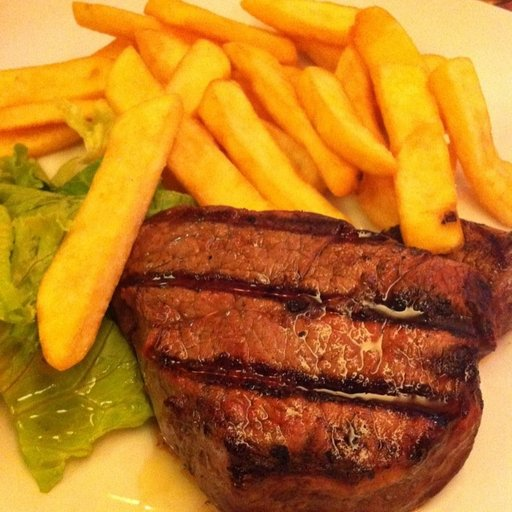

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

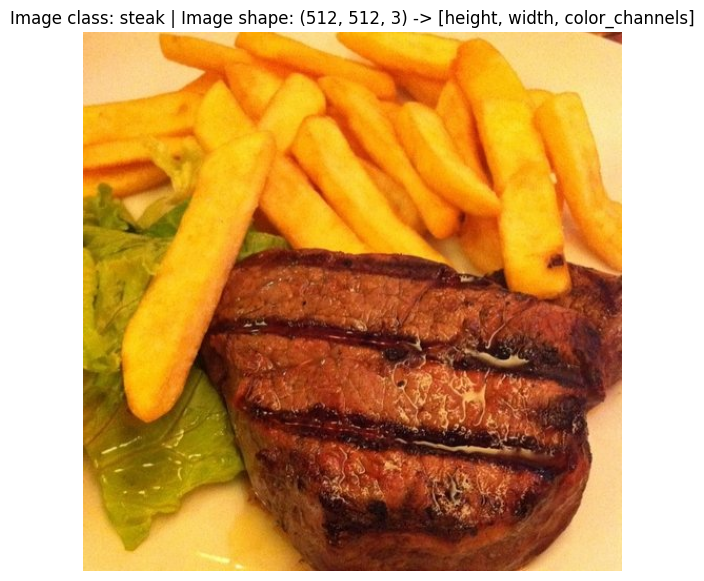

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming data

- Langkah selanjutnya adalah mengubah data gambar menjadi format yang dapat digunakan oleh PyTorch.
- Untuk melakukannya, kita perlu mengubah gambar-gambar tersebut menjadi tensor (representasi numerik dari gambar) dan membuat `torch.utils.data.Dataset` dan `torch.utils.data.DataLoader`.
- Terdapat beberapa jenis dataset dan loader bawaan untuk PyTorch, tergantung pada masalah yang sedang dihadapi.
- Pada kasus ini, karena kita bekerja dengan masalah computer vision, kita akan menggunakan [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) untuk fungsi pemuatan data dan [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) untuk persiapan data.


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

- Dalam langkah ini, kita akan menggunakan modul `torchvision.transforms` untuk mentransformasi data gambar menjadi tensor dan melakukan augmentasi data jika diperlukan.
- Modul ini menyediakan berbagai metode bawaan untuk memformat gambar, mengonversinya menjadi tensor, dan bahkan melakukan manipulasi untuk **augmentasi data** (praktik mengubah data untuk membuatnya lebih sulit bagi model untuk mempelajarinya).
- Kita akan membuat serangkaian transformasi yang melibatkan resize gambar, flip horizontal secara acak, dan konversi gambar menjadi tensor.
- Transformasi ini akan digabungkan menggunakan [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).
- Selanjutnya, kita akan membuat fungsi `plot_transformed_images` untuk mencoba transformasi pada beberapa gambar acak.
- Fungsi ini membuka beberapa path gambar dari daftar path yang diberikan, menerapkan transformasi, dan menampilkannya secara berdampingan.
- Selanjutnya, kita akan menguji transformasi ini pada beberapa gambar dari dataset yang telah kita unduh.
- Transformasi tersebut melibatkan resize gambar, flip horizontal secara acak, dan konversi gambar menjadi tensor.
- Kita juga melihat bahwa ukuran gambar sebelum dan sesudah transformasi telah berubah, serta label kelas gambar tersebut ditampilkan.
- Transformasi ini berguna untuk memastikan bahwa model dapat melihat variasi data yang lebih besar, meskipun lebih banyak piksel membutuhkan lebih banyak perhitungan.
- Oleh karena itu, transformasi ini dapat membantu dalam proses pelatihan model.


In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

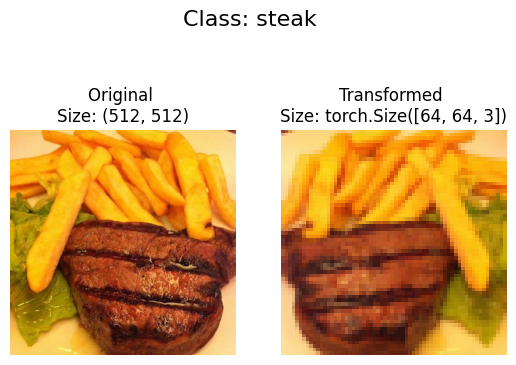

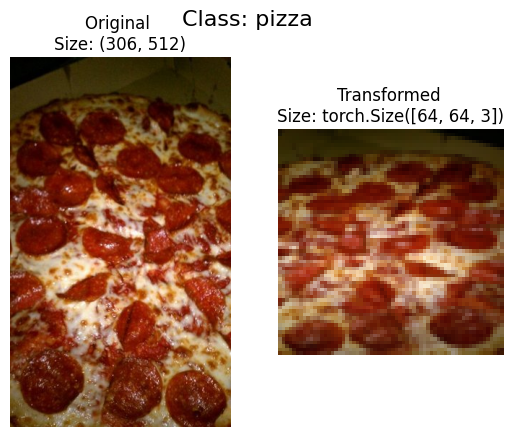

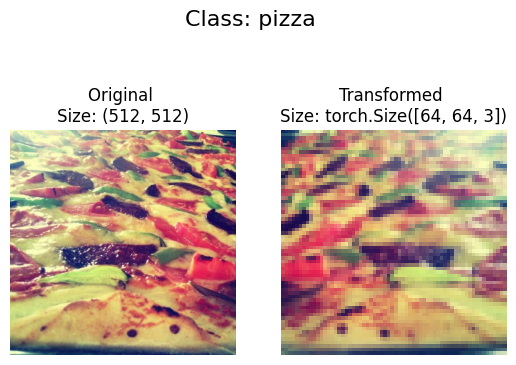

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

- Pada langkah ini, kita akan menggunakan [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder) untuk membuat dataset yang dapat digunakan dengan PyTorch.
- Kita memberikan path folder target gambar serta serangkaian transformasi yang ingin kita terapkan pada gambar menggunakan parameter `transform`.
- Kita menguji menggunakan folder `train_dir` dan `test_dir` dengan memberikan parameter `transform=data_transform` untuk mengubah gambar menjadi tensor.
- PyTorch berhasil mendaftarkan dataset kita, dan kita dapat memeriksanya dengan melihat atribut `classes` dan `class_to_idx` serta panjang dari set pelatihan dan pengujian.
- Kita dapat mengakses nama-nama kelas, mengonversinya menjadi dictionary, dan mengecek panjang dataset pelatihan dan pengujian.
- Kita juga dapat mengakses gambar dan label dari dataset menggunakan indexing pada objek `Dataset`.
- Gambar sekarang berbentuk tensor (dengan bentuk `[3, 64, 64]`) dan label berupa integer yang berkaitan dengan kelas tertentu.
- Kita juga mencoba menampilkan satu tensor gambar menggunakan `matplotlib`. Karena format dimensinya berbeda antara PyTorch dan `matplotlib`, kita perlu menggunakan `permute` untuk menyusun ulang dimensinya.
- Plot gambar menunjukkan bahwa gambar sekarang lebih kecil karena telah diubah ukurannya dari `512x512` menjadi `64x64` piksel.
- Pengecilan ukuran ini bertujuan untuk membuat gambar lebih sulit dikenali, dan hal ini dapat membantu model untuk memahami variasi yang lebih besar dalam data.


In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


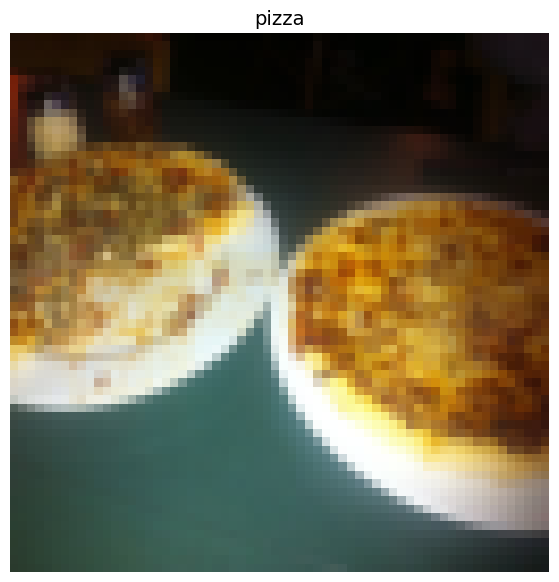

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`'s

- Setelah memuat gambar sebagai `Dataset` PyTorch, kita akan mengubahnya menjadi `DataLoader` menggunakan [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
- Mengubah `Dataset` menjadi `DataLoader` membuatnya dapat diiterasi sehingga model dapat mempelajari hubungan antara sampel dan target (fitur dan label).
- Untuk sederhananya, kita menggunakan `batch_size=1` dan `num_workers=1`.
- `num_workers` menentukan berapa banyak subprocess yang akan dibuat untuk memuat data. Semakin tinggi nilai `num_workers`, semakin banyak daya komputasi yang akan digunakan oleh PyTorch untuk memuat data.
- Biasanya, kita dapat mengatur `num_workers` ke jumlah total CPU di mesin kita menggunakan `os.cpu_count()`.
- Kita telah berhasil membuat `DataLoader` untuk data pelatihan dan pengujian, dan sekarang data kita dapat diiterasi.
- Kita mencoba menggunakan `DataLoader` dengan satu iterasi dan mengecek bentuknya.
- Kita dapat menggunakan `DataLoader` ini dalam loop pelatihan dan pengujian untuk melatih model.
- Sebelum melakukannya, mari kita lihat opsi lain untuk memuat gambar (atau hampir semua jenis data lainnya).



In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a45054d9570>,
 <torch.utils.data.dataloader.DataLoader at 0x7a45054db1c0>)

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

- Jika tidak ada pembuat `Dataset` bawaan yang sesuai atau tidak ada yang cocok dengan masalah spesifik yang kita hadapi, kita dapat membuat `Dataset` kustom.
- Pro dari pembuatan `Dataset` kustom termasuk kemampuan untuk membuat `Dataset` dari hampir apa saja dan tidak terbatas pada fungsi bawaan PyTorch.
- Namun, ada beberapa kontra, seperti penulisan lebih banyak kode yang mungkin rentan terhadap kesalahan atau masalah kinerja.
- Saat membuat `Dataset` kustom, kita dapat membuat subkelas `torch.utils.data.Dataset` untuk menangani logika pemrosesan data khusus yang diperlukan oleh dataset kita.
- Langkah-langkah pembuatan `Dataset` kustom melibatkan penggunaan `__init__` untuk inisialisasi, `__len__` untuk mengembalikan panjang dataset, dan `__getitem__` untuk mengakses item dataset berdasarkan indeksnya.
- Fungsi `__getitem__` dapat digunakan untuk membuka dan memproses gambar, serta mengembalikan pasangan gambar dan label dalam format yang dapat digunakan oleh model PyTorch.
- Dengan membuat `Dataset` kustom, kita mendapatkan kendali penuh atas cara data kita dimuat, diproses, dan disiapkan untuk model pembelajaran mesin.

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [21]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

- Fungsi pembantu `find_classes` dibuat untuk mendapatkan daftar nama kelas dan kamus nama kelas dan indeks numeriknya dari sebuah direktori target.
- Fungsi ini mengasumsikan bahwa direktori target berada dalam format klasifikasi gambar standar, di mana setiap kelas memiliki folder terpisah.
- Langkah pertama adalah mendapatkan nama-nama kelas dengan menggunakan `os.scandir()` untuk menelusuri direktori target.
- Jika nama-nama kelas tidak ditemukan, fungsi ini akan memunculkan kesalahan dan memberikan pesan bahwa tidak dapat menemukan kelas apa pun di direktori tersebut.
- Langkah terakhir adalah membuat kamus yang mengaitkan nama kelas dengan indeks numerik (komputer lebih suka label numerik daripada string).

Dengan menggunakan fungsi ini, kita dapat dengan mudah mendapatkan informasi tentang nama-nama kelas dan indeks numeriknya dari suatu direktori.

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [23]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [24]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

- Telah dibuat kelas khusus `ImageFolderCustom` yang merupakan turunan dari `torch.utils.data.Dataset`.
- Kelas ini diinisialisasi dengan parameter `targ_dir` (direktori data target) dan `transform` (opsional untuk mentransformasi data).
- Berbagai atribut seperti `paths` (jalur gambar target), `transform` (transformasi yang mungkin ingin digunakan), `classes`, dan `class_to_idx` (dari fungsi `find_classes`) dibuat.
- Fungsi `load_image` digunakan untuk membuka gambar dari jalur dan mengembalikannya sebagai objek `Image`.
- Fungsi `__len__` digunakan untuk mengembalikan jumlah total sampel dalam dataset.
- Fungsi `__getitem__` digunakan untuk mengembalikan satu sampel data, berupa data dan label (X, y).
- Dua objek dataset baru (`train_data_custom` dan `test_data_custom`) telah dibuat menggunakan kelas `ImageFolderCustom`.
- Transformasi telah dibuat untuk menyiapkan gambar, terdiri dari transformasi pelatihan dan transformasi pengujian.
- Kesetaraan dan konsistensi diuji dengan membandingkan panjang dataset, kelas, dan class_to_idx.
- Sejumlah gambar acak telah diplot untuk menguji penggantian `__getitem__`.

Dengan langkah-langkah ini, kita telah berhasil membuat dataset kustom yang setara dengan `torchvision.datasets.ImageFolder()` dan menguji fungsionalitasnya.

In [25]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [26]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a4505502050>,
 <__main__.ImageFolderCustom at 0x7a4505501bd0>)

In [28]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [29]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [30]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [31]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


### 5.3 Create a function to display random images

- Telah dibuat fungsi bantuan `display_random_images()` untuk menampilkan gambar secara acak dari dataset.
- Fungsi ini menerima parameter seperti `Dataset`, `classes` (nama-nama kelas), jumlah gambar yang akan ditampilkan (`n`), apakah menampilkan bentuk gambar (`display_shape`), dan seed acak.
- Menangani batas tampilan jika `n` terlalu tinggi, membatasi maksimalnya menjadi 10 gambar dan menghilangkan tampilan bentuk gambar.
- Mengatur seed acak untuk plot yang dapat direproduksi (jika `seed` diatur).
- Mendapatkan daftar indeks sampel acak untuk diplot.
- Menyiapkan plot `matplotlib`.
- Melakukan loop melalui indeks sampel acak dan menampilkannya dengan `matplotlib`.
- Menyesuaikan bentuk tensor gambar agar sesuai untuk plotting.
- Menguji fungsi dengan dataset yang dibuat dengan `torchvision.datasets.ImageFolder()` dan dataset yang dibuat dengan `ImageFolderCustom`.

Dengan fungsi ini, kita dapat dengan mudah mengeksplorasi dan memvisualisasikan data pada dataset kita.

In [32]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

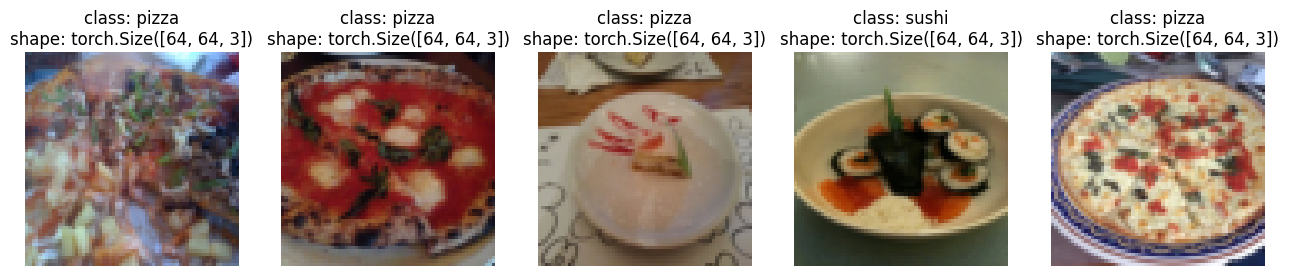

In [33]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


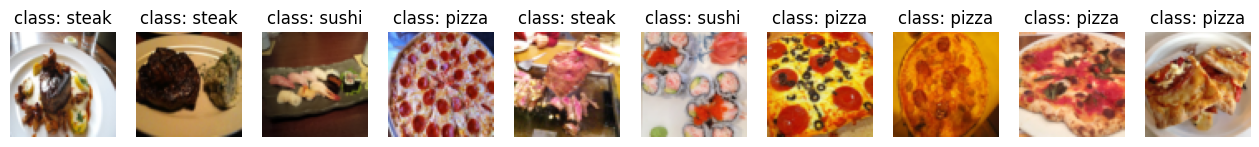

In [34]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into `DataLoader`'s

- Dataset yang telah di-load menggunakan `ImageFolderCustom` dapat diubah menjadi `DataLoader` menggunakan `torch.utils.data.DataLoader`.
- Prosedur ini mirip dengan yang digunakan sebelumnya untuk `torchvision.datasets.ImageFolder()`.
- DataLoader dibuat dengan menggunakan parameter seperti dataset yang telah dibuat (`train_data_custom` atau `test_data_custom`), ukuran batch (`batch_size`), jumlah pekerja (`num_workers`), dan apakah data perlu diacak (`shuffle`).
- Kemudian, dilakukan pengambilan satu batch data dari DataLoader untuk memeriksa bentuk sampelnya.
- Dengan ini, kita dapat menggunakan DataLoader untuk melatih dan menguji model pada dataset yang telah kita siapkan.

In [35]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a450565a380>,
 <torch.utils.data.dataloader.DataLoader at 0x7a4505791d20>)

In [36]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)

- Transformasi data atau data augmentation adalah proses mengubah data dengan cara tertentu untuk meningkatkan keberagaman dataset pelatihan.
- PyTorch menyediakan berbagai macam transformasi melalui modul `torchvision.transforms`.
- Beberapa transformasi yang umum digunakan termasuk `Resize`, `RandomHorizontalFlip`, dan `ToTensor`.
- Data augmentation bertujuan untuk meningkatkan kemampuan umum model dalam memahami pola pada data baru yang belum pernah dilihat.
- `TrivialAugmentWide` adalah salah satu teknik data augmentation yang dapat digunakan untuk secara acak menggabungkan beberapa transformasi pada gambar dengan intensitas yang bervariasi.
- Transformasi data biasanya diterapkan saat membuat objek `Dataset` dan dapat diintegrasikan dengan objek `DataLoader` untuk melatih dan menguji model.

In [37]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

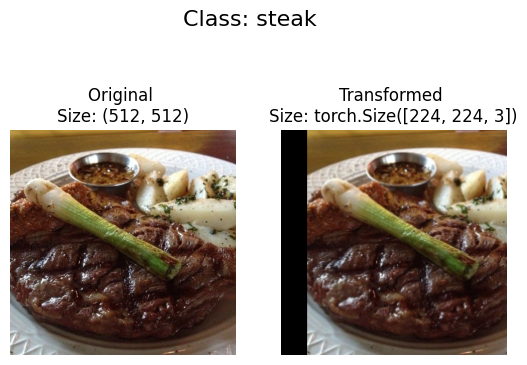

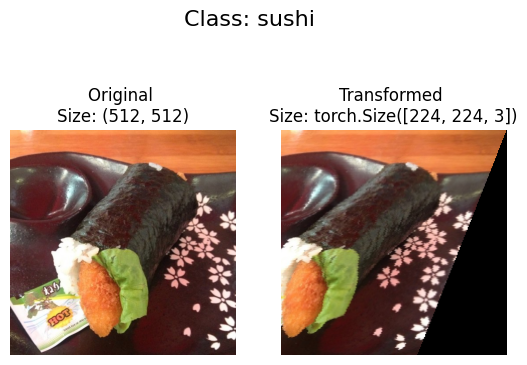

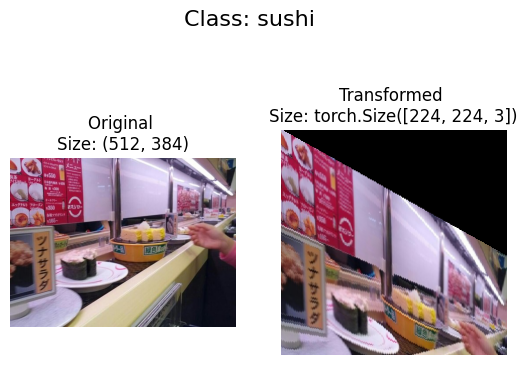

In [38]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation

- Model yang pertama kali dibangun adalah TinyVGG.
- Transformasi yang digunakan hanya mencakup perubahan ukuran gambar menjadi `(64, 64)` dan mengubahnya menjadi tensor.
- TinyVGG adalah model sederhana yang terinspirasi dari arsitektur VGG (Visual Geometry Group).
- TinyVGG terdiri dari beberapa lapisan konvolusi dan lapisan linier, yang diikuti oleh fungsi aktivasi ReLU dan lapisan dropout untuk mencegah overfitting.
- Model ini tidak menggunakan augmentasi data pada tahap awal.
- Model tersebut kemudian dapat dilatih menggunakan dataloader yang telah dibuat sebelumnya untuk dataset pelatihan dan pengujian.

### 7.1 Creating transforms and loading data for Model 0

- Model yang dibangun adalah TinyVGG, terinspirasi dari arsitektur VGG.
- Model memiliki beberapa lapisan konvolusi dan lapisan linier.
- Untuk mencegah overfitting, diimplementasikan fungsi dropout setelah lapisan linier.
- Model ini belum menggunakan augmentasi data pada tahap awal.
- Data telah diubah menggunakan transformasi yang sederhana, seperti meresize gambar menjadi ukuran `(64, 64)` dan mengonversinya menjadi tensor.
- Dataloader telah dibuat untuk kedua dataset pelatihan dan pengujian dengan batch size sebesar 32 dan jumlah pekerja sebanyak CPU yang tersedia pada mesin.

In [39]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [40]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7a45052ebbb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a45052eb700>)

### 7.2 Create TinyVGG model class

- Kelas model TinyVGG dibuat untuk arsitektur TinyVGG yang diambil dari situs [CNN Explainer](https://poloclub.github.io/cnn-explainer/).
- Model ini dirancang untuk memproses citra warna, sehingga memiliki `input_shape=3` untuk 3 saluran warna (RGB).
- Terdapat dua blok konvolusi (`conv_block_1` dan `conv_block_2`), masing-masing diikuti dengan fungsi aktivasi ReLU dan lapisan pemampatan maksimal (max-pooling).
- Blok klasifikasi terdiri dari lapisan pemadatan (`Flatten()`) dan lapisan linier (`Linear()`).
- Model menerima input citra dengan ukuran `(64, 64)` dan menghasilkan keluaran dengan jumlah kelas yang sesuai dengan jumlah kelas dalam dataset pelatihan.
- Fungsi `forward` menggambarkan aliran input melalui seluruh model.
- Model ini telah diinisialisasi dengan seed tetap untuk reproducibility.

Sekarang, kita akan melakukan proses forward pass pada satu citra untuk menguji model ini.

In [41]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image (to test the model)
- Untuk menguji model, kita melakukan forward pass pada satu citra menggunakan fungsi `model_0.eval()` untuk memastikan bahwa model berada dalam mode evaluasi (bukan pelatihan).
- Citra tersebut diambil dari batch yang diperoleh dari `DataLoader`.
- Kita menggunakan `unsqueeze(dim=0)` untuk menambah dimensi batch sehingga bentuk citra sesuai dengan model yang membutuhkan dimensi batch.
- Setelah itu, kita melakukan inferensi pada satu citra dengan memindahkan citra ke perangkat target (`device`).
- Output dari model berupa logits, yang kemudian diubah menjadi probabilitas prediksi menggunakan `torch.softmax()` karena kita berurusan dengan data multi-kelas. Selanjutnya, kita mengonversi probabilitas prediksi menjadi label prediksi dengan `torch.argmax()`.
- Output probabilitas prediksi, label prediksi, dan label aktual kemudian dicetak untuk dianalisis.

Sekarang, kita telah mengonfirmasi bahwa model berfungsi dan dapat menghasilkan prediksi pada satu citra. Selanjutnya, kita akan melatih model ini pada dataset pelatihan.

In [42]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

- Kita menggunakan `torchinfo` untuk mendapatkan informasi lebih detail tentang model kita.
- `torchinfo.summary()` memberikan informasi terkait jumlah total parameter, ukuran perkiraan total model (dalam MB), dan perubahan bentuk input dan output saat data bergerak melalui model.
- Informasi ini sangat membantu untuk melihat keseluruhan struktur model dan parameter yang terlibat.
- Saat ini, model kita memiliki jumlah parameter dan ukuran total model yang rendah, yang sesuai dengan model awal yang relatif kecil.
- Pada tahap selanjutnya, kita akan melatih model ini pada dataset pelatihan.

In [43]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

### 7.5 Create train & test loop functions

- Dibuat fungsi `train_step()` yang berfungsi untuk melakukan satu langkah pelatihan pada model.
- Fungsi ini menerima model, dataloader, fungsi loss, dan optimizer sebagai parameter.
- Fungsi `train_step()` mengembalikan nilai rata-rata loss dan akurasi pelatihan per batch.
- Dibuat juga fungsi `test_step()` dengan fungsi yang serupa dengan `train_step()`.
- Perbedaan utama adalah `test_step()` tidak menerima optimizer karena tidak melibatkan perhitungan gradien dan optimasi.
- Keduanya mengembalikan nilai rata-rata loss dan akurasi per batch pada set pelatihan atau pengujian.

In [44]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [45]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc



### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

- Dibuat fungsi `train()` untuk melakukan pelatihan dan evaluasi model.
- Fungsi ini menerima model, DataLoader untuk set pelatihan dan pengujian, optimizer, fungsi loss, dan jumlah epoch.
- Membuat dictionary kosong (`results`) untuk menyimpan nilai `train_loss`, `train_acc`, `test_loss`, dan `test_acc`.
- Melakukan loop melalui langkah-langkah pelatihan dan pengujian untuk sejumlah epoch yang ditentukan.
- Menampilkan informasi tentang loss dan akurasi pelatihan dan pengujian setiap epoch.
- Mengupdate dictionary `results` dengan nilai terkini setiap epoch.
- Mengembalikan dictionary `results` yang telah diisi setelah selesai epoch.

In [46]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 7.7 Train and Evaluate Model 0
- Membuat model `model_0` menggunakan arsitektur TinyVGG.
- Menentukan jumlah epoch yang akan dilakukan sebanyak 5 kali.
- Menggunakan fungsi loss `torch.nn.CrossEntropyLoss()` karena data klasifikasi multi-kelas dan optimizer `torch.optim.Adam()` dengan learning rate sebesar `1e-3`.
- Mengukur waktu pelatihan menggunakan `timeit.default_timer()` sebelum dan sesudah pelatihan.
- Menjalankan pelatihan model menggunakan fungsi `train()` dengan parameter yang sesuai.
- Menampilkan total waktu pelatihan setelah selesai.

In [47]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1696 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0988 | train_acc: 0.4141 | test_loss: 1.1344 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0990 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Total training time: 7.046 seconds


### 7.8 Plot the loss curves of Model 0

- Membuat fungsi `plot_loss_curves` untuk menampilkan kurva loss dari hasil pelatihan model.
- Mengambil nilai loss dan akurasi dari dictionary hasil pelatihan model (`model_0_results`).
- Menampilkan kurva loss dan akurasi pada dua subplot yang berbeda (train dan test) menggunakan `matplotlib`.
- Menyimpulkan bahwa performa model tidak begitu baik berdasarkan hasil kurva loss dan akurasi. Pelatihan lebih lanjut atau perubahan pada arsitektur model mungkin diperlukan.

In [48]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [49]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

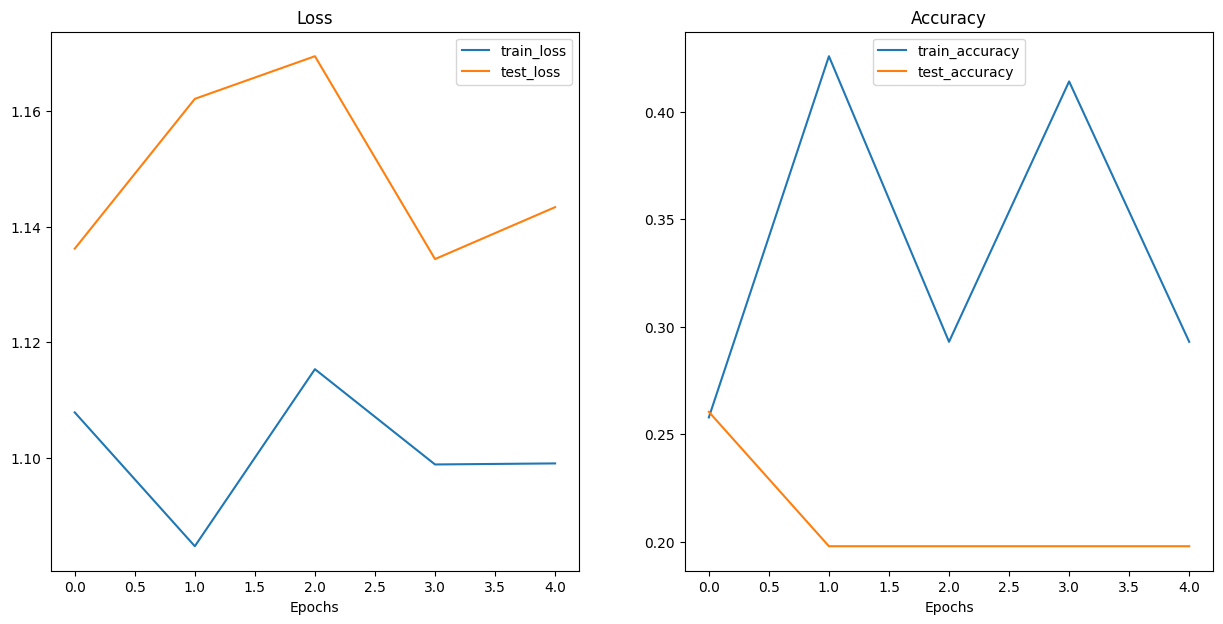

In [50]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

- Grafik kurva loss yang ideal adalah saat kurva loss pelatihan dan validasi/test berdekatan satu sama lain.
- Jika kurva loss pelatihan lebih rendah daripada kurva loss validasi/test, itu menunjukkan **overfitting**.
- Overfitting terjadi saat model mempelajari pola pada data pelatihan terlalu baik, tetapi pola tersebut tidak umum pada data uji.
- Jika kedua kurva loss pelatihan dan validasi/test tidak rendah, itu disebut **underfitting**.
- Posisi ideal adalah saat kedua kurva loss berdekatan, menunjukkan bahwa model umumnya dapat menggeneralisasi dengan baik pada data uji.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>


### 8.1 How to deal with overfitting

- **Dapatkan lebih banyak data:** Menambahkan lebih banyak data memberikan model lebih banyak peluang untuk mempelajari pola, yang mungkin lebih generalisasi untuk contoh baru.
  
- **Sederhanakan model:** Jika model saat ini sudah overfitting pada data pelatihan, mungkin terlalu rumit. Cara untuk menyederhanakan model adalah dengan mengurangi jumlah lapisan atau mengurangi jumlah unit tersembunyi di setiap lapisan.

- **Gunakan augmentasi data:** Augmentasi data memanipulasi data pelatihan untuk membuatnya lebih sulit bagi model untuk belajar, karena menambahkan variasi buatan pada data. Jika model dapat mempelajari pola pada data yang di-augmentasi, model mungkin dapat menggeneralisasi dengan lebih baik pada data yang belum terlihat.

- **Gunakan transfer learning:** Transfer learning melibatkan pemanfaatan pola (atau bobot yang telah dilatih) yang telah dipelajari oleh satu model untuk digunakan sebagai dasar untuk tugas Anda sendiri. Sebagai contoh, kita dapat menggunakan model computer vision yang telah dilatih pada berbagai gambar dan kemudian menyesuaikannya sedikit untuk menjadi lebih khusus untuk gambar makanan.

- **Gunakan dropout layers:** Dropout layers secara acak menghapus koneksi antara lapisan tersembunyi dalam jaringan saraf, secara efektif menyederhanakan model tetapi juga membuat koneksi yang tersisa lebih baik.

- **Gunakan learning rate decay:** Ide di sini adalah secara perlahan mengurangi learning rate saat model melatih. Hal ini mirip dengan mencoba mencapai koin di belakang sofa. Semakin dekat Anda mendekat, semakin kecil langkah-langkah Anda. Begitu juga dengan learning rate, semakin dekat Anda mendekati [konvergensi](https://developers.google.com/machine-learning/glossary#convergence), semakin kecil Anda ingin pembaruan bobot Anda.

- **Gunakan early stopping:** Early stopping menghentikan pelatihan model *sebelum* ia mulai overfitting. Jika kerugian model telah berhenti menurun selama 10 epoch terakhir (angka ini sewenang-wenang), Anda mungkin ingin menghentikan pelatihan model di sini dan menggunakan bobot model yang memiliki kerugian terendah (10 epoch sebelumnya).

Terdapat metode lain untuk mengatasi overfitting, tetapi ini adalah beberapa di antaranya. Saat Anda membangun model yang lebih dalam, Anda akan menemukan bahwa mengatasi overfitting adalah salah satu masalah utama dalam deep learning.

### 8.2 How to deal with underfitting

- **Tambahkan lebih banyak lapisan/unit pada model Anda:** Jika model Anda mengalami underfitting, mungkin tidak memiliki kemampuan yang cukup untuk *mempelajari* pola/bobot/representasi yang diperlukan dari data agar dapat memprediksi. Salah satu cara untuk menambah daya prediktif model Anda adalah dengan menambah jumlah lapisan tersembunyi/unit dalam lapisan tersebut.

- **Atur kembali learning rate:** Mungkin learning rate model Anda terlalu tinggi pada awalnya. Dan model mencoba untuk memperbarui bobotnya setiap epoch terlalu banyak, sehingga tidak belajar apa-apa. Dalam hal ini, Anda mungkin ingin menurunkan learning rate dan melihat apa yang terjadi.

- **Gunakan transfer learning:** Transfer learning mampu mencegah overfitting dan underfitting. Ini melibatkan penggunaan pola dari model yang sudah berfungsi sebelumnya dan menyesuaikannya dengan masalah Anda sendiri.

- **Latih lebih lama:** Kadang-kadang sebuah model hanya perlu lebih banyak waktu untuk mempelajari representasi data. Jika Anda menemukan dalam eksperimen kecil Anda bahwa model Anda tidak belajar apa-apa, mungkin membiarkannya melatih untuk lebih banyak epoch dapat menghasilkan kinerja yang lebih baik.

- **Gunakan lebih sedikit regularisasi:** Mungkin model Anda mengalami underfitting karena Anda mencoba mencegah overfitting terlalu banyak. Mengurangi penggunaan teknik regularisasi dapat membantu model Anda lebih baik dalam menyesuaikan data.

### 8.3 The balance between overfitting and underfitting

Tidak ada metode yang dibahas di atas yang merupakan solusi mutlak, yang berarti, mereka tidak selalu berhasil.

Mencegah overfitting dan underfitting mungkin merupakan area penelitian paling aktif dalam machine learning.

Karena semua orang ingin model mereka lebih sesuai (kurang underfitting), tetapi tidak terlalu baik sehingga mereka tidak generalisasi dengan baik dan berkinerja di dunia nyata (kurang overfitting).

Ada batas tipis antara overfitting dan underfitting.

Karena terlalu banyak dari masing-masing dapat menyebabkan yang lain.

Transfer learning mungkin salah satu teknik paling kuat ketika dealing dengan kedua masalah overfitting dan underfitting pada masalah Anda sendiri.

Daripada membuat sendiri berbagai teknik overfitting dan underfitting, transfer learning memungkinkan Anda mengambil model yang sudah bekerja di ruang masalah yang mirip dengan milik Anda (misalnya dari [paperswithcode.com/sota](https://paperswithcode.com/sota) atau [Hugging Face models](https://huggingface.co/models)) dan menerapkannya pada kumpulan data Anda sendiri.


## 9. Model 1: TinyVGG with Data Augmentation

Kali ini, mari muat data dan gunakan **data augmentation** untuk melihat apakah itu meningkatkan hasil kita dengan cara apa pun.

Pertama, kita akan menyusun transformasi pelatihan untuk mencakup `transforms.TrivialAugmentWide()` serta meresize dan mengubah gambar menjadi tensor.

Kita akan melakukan hal yang sama untuk transformasi pengujian kecuali tanpa augmentasi data.

Sekarang kita memiliki transformasi untuk digunakan pada data pelatihan dan pengujian dengan dan tanpa augmentasi data. Selanjutnya, kita akan membuat kumpulan data dan loader untuk keduanya.

### 9.1 Create transform with data augmentation

In [51]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])


1. **Inisialisasi `ImageFolder` untuk Dataset Pelatihan dan Pengujian:** Gunakan `ImageFolder` dari `torchvision.datasets` untuk membuat dataset pelatihan dan pengujian dari struktur direktori.
2. **Terapkan Transformasi pada Dataset:** Terapkan transformasi yang sesuai pada dataset pelatihan dan pengujian menggunakan transformasi yang telah dibuat sebelumnya.


### 9.2 Create train and test `Dataset`'s and `DataLoader`'s

1. **Buat DataLoader:** Konversi dataset pelatihan dan pengujian ke dalam DataLoader menggunakan `torch.utils.data.DataLoader`.
2. **Buat Struktur Direktori yang Sesuai:** Pastikan struktur direktori untuk dataset pelatihan dan pengujian sesuai dengan yang diharapkan oleh `ImageFolder`.

In [52]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [53]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a4505313e80>,
 <torch.utils.data.dataloader.DataLoader at 0x7a45054db1c0>)

### 9.3 Construct and train Model 1

1. **Inisialisasi Model `TinyVGG`**: Membuat instance dari model `TinyVGG` sebagai `model_1` dengan konfigurasi input layer sejumlah 3, hidden units 10, dan output layer sejumlah jumlah kelas pada dataset augmented.
2. **Pembuatan Fungsi Loss dan Optimizer**: Menggunakan `torch.nn.CrossEntropyLoss()` sebagai fungsi loss dan `torch.optim.Adam()` dengan `learning rate` sebesar 0.001 sebagai optimizer.
3. **Pelatihan Model**: Melakukan pelatihan model dengan memanggil fungsi `train()` dengan parameter yang sesuai, termasuk dataset pelatihan yang telah di-augmentasi.
4. **Evaluasi Waktu Pelatihan**: Merekam waktu yang diperlukan untuk pelatihan menggunakan `timeit` dan mencetaknya.



In [54]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [55]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1292 | train_acc: 0.3047 | test_loss: 1.1624 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0900 | train_acc: 0.4258 | test_loss: 1.1481 | test_acc: 0.2604
Total training time: 7.374 seconds


### 9.4 Plot the loss curves of Model 1

1. **Visualisasi Loss Curves Model 1**: Membuat visualisasi loss curves untuk `model_1` menggunakan fungsi `plot_loss_curves(model_1_results)`.
2. **Analisis Hasil**: Menyatakan bahwa hasil visualisasi tidak terlihat baik dan kemungkinan model mengalami underfitting atau overfitting, atau keduanya.
3. **Tujuan Ideal**: Mengungkapkan bahwa tujuan yang diinginkan adalah mencapai akurasi yang lebih tinggi dan loss yang lebih rendah.
4. **Strategi Perbaikan**: Menanyakan ide atau strategi apa yang dapat digunakan untuk memperbaiki performa model tersebut, termasuk cara mengatasi underfitting dan overfitting.



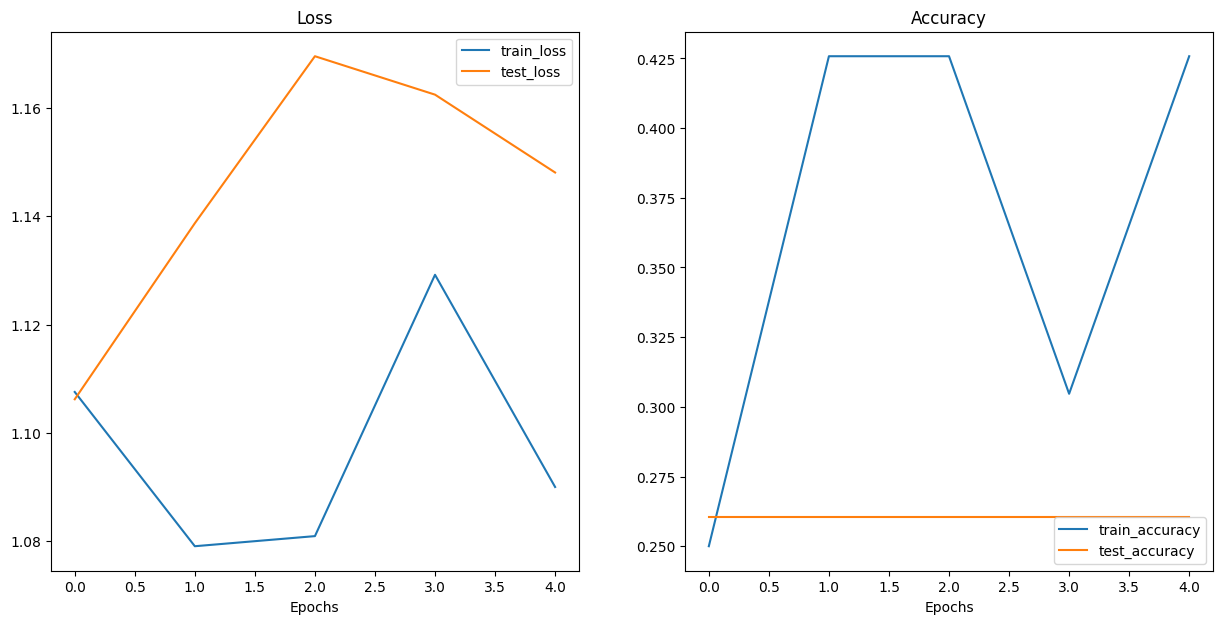

In [56]:
plot_loss_curves(model_1_results)

## 10. Compare model results

1. **Konversi Hasil Model ke DataFrame**: Menggunakan pandas, hasil dari `model_0` dan `model_1` dikonversi ke dalam DataFrame.
2. **Visualisasi Loss dan Accuracy**: Menggunakan `matplotlib`, melakukan visualisasi hasil loss dan accuracy dari kedua model selama beberapa epochs.


In [57]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162168,0.197917
2,1.115324,0.292969,1.169554,0.197917
3,1.098812,0.414062,1.134404,0.197917
4,1.098995,0.292969,1.143399,0.197917


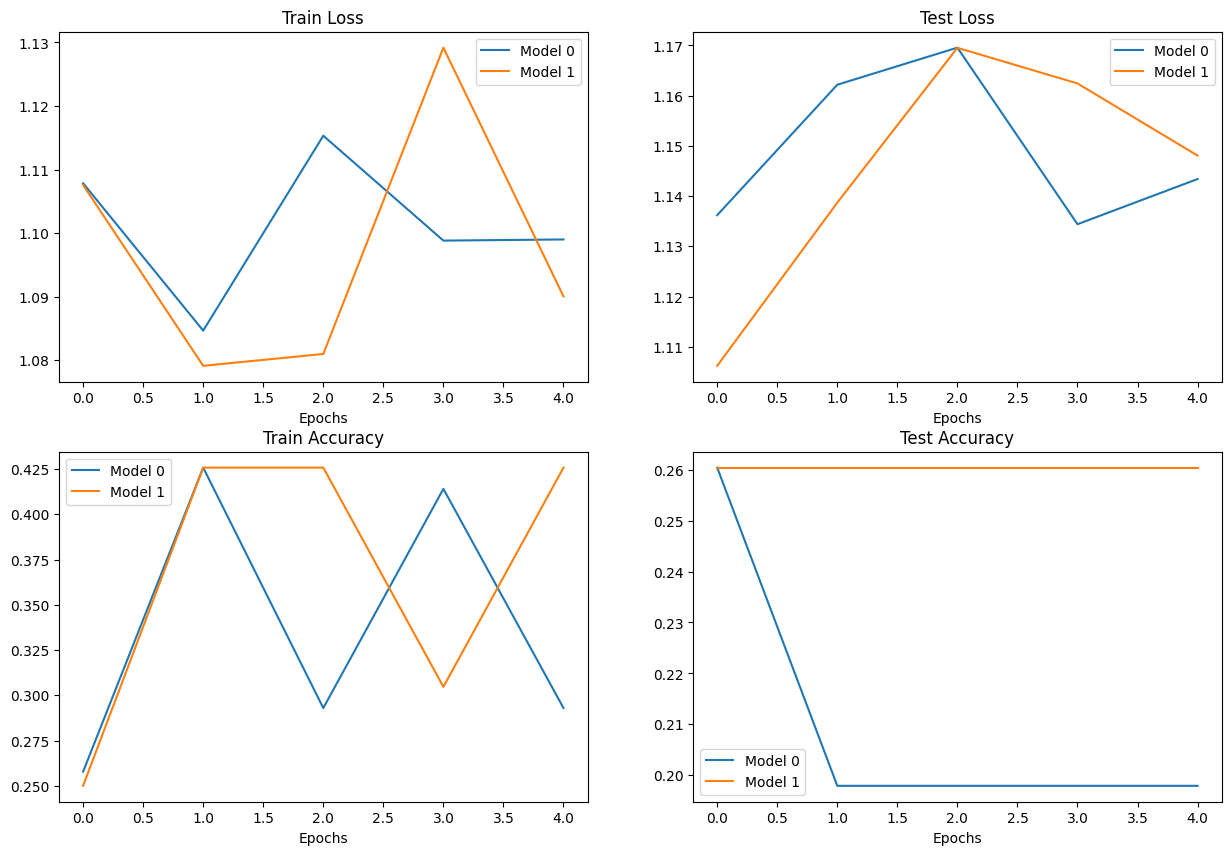

In [58]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11. Make a prediction on a custom image

1. **Unduh Gambar Kustom**: Menggunakan modul `requests`, gambar kustom (gambar pizza dari GitHub) diunduh.
2. **Path Gambar Kustom**: Menetapkan path untuk gambar kustom tersebut.
3. **Cek Ketersediaan Gambar**: Mengecek apakah gambar sudah ada. Jika belum, maka gambar diunduh dari GitHub menggunakan `requests`.
4. **Informasi Status**: Memberikan informasi apakah gambar telah diunduh atau sudah ada.


In [59]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 11.1 Loading in a custom image with PyTorch

1. **Baca Gambar Kustom**: Menggunakan [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image), gambar kustom dibaca dan dikonversi menjadi tensor PyTorch.
2. **Format Tensor**: Memeriksa format tensor hasil bacaan, yang mana bertipe data `uint8` dan memiliki nilai dalam rentang `[0, 255]`.
3. **Pemrosesan untuk Prediksi**: Menyesuaikan format tensor agar sesuai dengan yang diterima oleh model (tipe data `float32` dan nilai dalam rentang `[0, 1]`).
4. **Print Informasi Tensor**: Menampilkan informasi terkait tensor gambar setelah penyesuaian.

In [60]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [61]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [62]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

### 11.2 Predicting on custom images with a trained PyTorch model

1. **Pemrosesan Gambar Kustom**: Mengonversi gambar kustom ke dalam format tensor yang sesuai dengan tipe data dan bentuk yang diterima oleh model (float32, CHW).
2. **Resize Gambar**: Menggunakan `torchvision.transforms.Resize()` untuk menyesuaikan ukuran gambar dengan yang digunakan oleh model (64x64 pixel).
3. **Prediksi dengan Model**: Memastikan model dan gambar kustom berada di perangkat yang sama dan memiliki dimensi batch yang sesuai sebelum melakukan prediksi.
4. **Melihat Hasil Prediksi**: Mengevaluasi hasil prediksi model terhadap gambar kustom, termasuk mengonversi nilai logit menjadi probabilitas dan label prediksi berdasarkan kelas yang telah ditentukan.

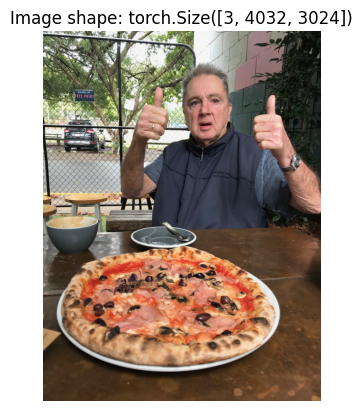

In [63]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [64]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [65]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [66]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [67]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [68]:
custom_image_pred

tensor([[ 0.1160,  0.0334, -0.1416]])

In [69]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1160,  0.0334, -0.1416]])
Prediction probabilities: tensor([[0.3713, 0.3418, 0.2869]])
Prediction label: tensor([0])


In [70]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

In [71]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3713, 0.3418, 0.2869]])

### 11.3 Putting custom image prediction together: building a function

1. **Fungsi Prediksi dan Plotting**: Membuat fungsi `pred_and_plot_image` yang menggabungkan langkah-langkah dari pemrosesan gambar kustom, prediksi model, dan plotting hasil prediksi.
2. **Pengujian Fungsi**: Menguji fungsi tersebut pada gambar kustom untuk melihat apakah dapat memberikan prediksi dan plot hasil prediksi dengan benar.

In [72]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

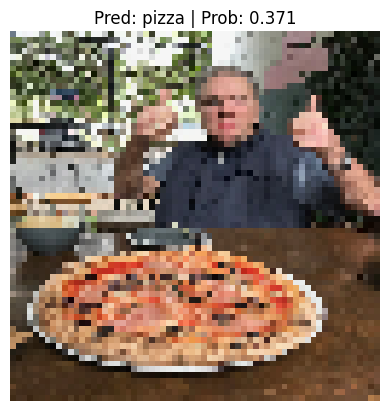

In [73]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)